**Table of contents**<a id='toc0_'></a>    
- [Mobile Robot Sensor](#toc1_)    
- [Starting pybullet](#toc2_)    
- [Lidar](#toc3_)    
  - [Definition of the Lidar Class](#toc3_1_)    
  - [Initial Setup](#toc3_2_)    
  - [Running the Simulation](#toc3_3_)    
- [Front Sensor](#toc4_)    
  - [Front Camera](#toc4_1_)    
    - [Initial Setup](#toc4_1_1_)    
    - [Running the Simulation](#toc4_1_2_)    
    - [Animating Captured Images](#toc4_1_3_)    
  - [Ultrasonic Sensor](#toc4_2_)    
    - [Definition of the Lidar Class](#toc4_2_1_)    
    - [Initial Setup](#toc4_2_2_)    
    - [Running the Simulation](#toc4_2_3_)    
- [Bumper](#toc5_)    
  - [Initial Setup](#toc5_1_)    
  - [Running the Simulation](#toc5_2_)    
- [Bottom Sensor](#toc6_)    
  - [Bottom Camera](#toc6_1_)    
    - [Initial Setup](#toc6_1_1_)    
    - [Running the Simulation](#toc6_1_2_)    
    - [Animating Captured Images](#toc6_1_3_)    
  - [Fall Prevention Sensor](#toc6_2_)    
    - [Definition of the Lidar Class](#toc6_2_1_)    
    - [Initial Setup](#toc6_2_2_)    
    - [Running the Simulation](#toc6_2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mobile Robot Sensor](#toc0_)

This notebook explains how to use the sensors mounted on a two-wheeled mobile robot.

Specifically, the mobile robot is equipped with the following sensors:
- Lidar
- Front Camera
- Ultrasonic Sensor
- Bumper
- Bottom Camera
- Fall Prevention Sensor

![](../images/MobileRobot/mobile_robot_sensor_en.png)

(For a manual summarizing the functions available in pybullet, please refer to [this link](https://github.com/bulletphysics/bullet3/blob/master/docs/pybullet_quickstartguide.pdf).)

# <a id='toc2_'></a>[Starting pybullet](#toc0_)

Starting pybullet.

From here on, each sensor has independent code, so you can try them in any order you like.  
(Note that functions used by other sensors are not explained in the later sensors, so if you want to understand the specific implementation details, it is recommended to read from the top in order.)

In [ ]:
import time
import math
import pybullet
import pybullet_data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
physics_client = pybullet.connect(pybullet.GUI) 

pybullet build time: Oct 23 2025 19:25:36


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Mesa
GL_RENDERER=llvmpipe (LLVM 20.1.2, 256 bits)
GL_VERSION=4.5 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.2
GL_SHADING_LANGUAGE_VERSION=4.50
pthread_getconcurrency()=0
Version = 4.5 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.2
Vendor = Mesa
Renderer = llvmpipe (LLVM 20.1.2, 256 bits)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


ven = Mesa
ven = Mesa


# <a id='toc3_'></a>[Lidar](#toc0_)

The lidar sensor is used to detect obstacles around the robot.

Compared to ultrasonic sensors, it has a higher detection range and accuracy, but it is more expensive.

## <a id='toc3_1_'></a>[Definition of the Lidar Class](#toc0_)

The lidar functionality is implemented using the `rayTestBatch` function of `pybullet`.

`rayTestBatch` is a function that performs ray casting with multiple rays.

Ray casting is the process of "drawing a line from a certain point in a specific direction and detecting whether there are any obstacles along that line," as shown in the figure below.

![raycast](../images/Common/raycast_explain.jpeg)


In [2]:
import math

class Lidar():
    def __init__(self):
        self.replace_item_uniqueIds = None

    # Rotation matrix representing orientation
    def rotation_matrix(self, roll, pitch, yaw):
        R_x = [[1, 0, 0],
                [0, math.cos(roll), -math.sin(roll)],
                [0, math.sin(roll), math.cos(roll)]]
        
        R_y = [[math.cos(pitch), 0, math.sin(pitch)],
                [0, 1, 0],
                [-math.sin(pitch), 0, math.cos(pitch)]]
        
        R_z = [[math.cos(yaw), -math.sin(yaw), 0],
                [math.sin(yaw), math.cos(yaw), 0],
                [0, 0, 1]]
        
        return np.dot(R_z, np.dot(R_y, R_x))

    def CheckHits(self, ray_from_position, ray_orientation, ray_length, angle_resolution_rad, ray_direction_range_rad, offset, draw_debug_line=False):
        """
        Ray casting for obstacle detection reflecting orientation
        Parameters
        ---
        ray_from_position : list
            List storing the starting position of the ray [x, y, z]
        orientation : list
            Orientation of the ray source [roll, pitch, yaw]
        ray_length : float
            Length of the ray
        angle_resolution_rad : float
            Angular resolution
        ray_direction_range_rad : list
            List storing the range of directions to cast rays [startRad, endRad]
        offset : float
            Offset from rayFromPosition
        draw_debug_line : bool
            Whether to draw the ray
        
        Returns
        ---
        hit_results: tuple
            Results of the ray casting
        """
        
        R = self.rotation_matrix(ray_orientation[0], ray_orientation[1], ray_orientation[2])
        
        # Number of divisions
        num_divisions = int((ray_direction_range_rad[1] - ray_direction_range_rad[0]) / angle_resolution_rad)

        # Generate ray start/end points within the range of ray_direction_range_rad for numDivisions
        ray_froms = []
        ray_toes = []
        for i in range(num_divisions):
            angle = ray_direction_range_rad[0] + i * angle_resolution_rad
            direction = [math.cos(angle), math.sin(angle), 0]
            
            # Rotate the direction vector by applying the rotation matrix
            rotated_direction = np.dot(R, direction)

            # Ray start point
            ray_from = ray_from_position + offset * rotated_direction
            ray_froms.append(ray_from)

            # Ray end point
            ray_to = ray_from + ray_length * rotated_direction
            ray_toes.append(ray_to)
        
        # Perform ray casting for numDivisions
        hit_results = pybullet.rayTestBatch(ray_froms, ray_toes)

        # Draw the rays
        if draw_debug_line:
            if self.replace_item_uniqueIds is None:
                self.replace_item_uniqueIds = []
                
                for i in range(num_divisions):
                    isHit = hit_results[i][0]
                    ray_from = ray_froms[i]
                    
                    if isHit != -1:
                        rayHitPosition = hit_results[i][3]
                        self.replace_item_uniqueIds.append(pybullet.addUserDebugLine(ray_from, rayHitPosition, lineColorRGB=[1,0,0]))
                    else:
                        rayToPosition = ray_toes[i]
                        self.replace_item_uniqueIds.append(pybullet.addUserDebugLine(ray_from, rayToPosition, lineColorRGB=[0,1,0]))
            
            else:
                for i in range(num_divisions):
                    isHit = hit_results[i][0]
                    ray_from = ray_froms[i]
                    
                    if isHit != -1:
                        rayHitPosition = hit_results[i][3]
                        pybullet.addUserDebugLine(ray_from, rayHitPosition, lineColorRGB=[1,0,0], replaceItemUniqueId=self.replace_item_uniqueIds[i])
                    else:
                        rayToPosition = ray_toes[i]
                        pybullet.addUserDebugLine(ray_from, rayToPosition, lineColorRGB=[0,1,0], replaceItemUniqueId=self.replace_item_uniqueIds[i])
        return hit_results


## <a id='toc3_2_'></a>[Initial Setup](#toc0_)

We will perform initial setup such as creating the floor, generating box objects, creating the robot, and setting the camera position.

In [3]:
pybullet.resetSimulation() # Reset the simulation space
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # Add path to necessary data for pybullet
pybullet.setGravity(0.0, 0.0, -9.8) # Set gravity as on Earth
time_step = 1./240.
pybullet.setTimeStep(time_step)

# Load the floor
plane_id = pybullet.loadURDF("plane.urdf")

# Load the boxes
## Determine the weight, size, position, and orientation of the boxes
# box1
mass = 5 # kg
box1_size = [0.3, 0.3, 0.3]
position2 = [2, 0, 0.3]
orientation2 = [1, 0, 0, 0] # Quaternion
box1_collision_id = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box1_size, physicsClientId=physics_client)
box1_visual_id = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box1_size, physicsClientId=physics_client, rgbaColor=[1,0,0,1]) # Red, semi-transparent
box1_body_id = pybullet.createMultiBody(mass, box1_collision_id, box1_visual_id, position2, orientation2, physicsClientId=physics_client)

# box2
mass = 5 # kg
box2_size = [0.3, 1.0, 0.3]
position2 = [-2, 0, 0.3]
orientation2 = [1, 0, 0, 0] # Quaternion
box2_collision_id = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box2_size, physicsClientId=physics_client)
box2_visual_id = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box2_size, physicsClientId=physics_client, rgbaColor=[1,0,0,1]) # Red, semi-transparent
box2_body_id = pybullet.createMultiBody(mass, box2_collision_id, box2_visual_id, position2, orientation2, physicsClientId=physics_client)

# Load the robot
car_start_pos = [0, 0, 0.1]  # Set the initial position (x, y, z)
car_start_orientation = pybullet.getQuaternionFromEuler([0, 0, 0])  # Set the initial orientation (roll, pitch, yaw)
car_id = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf", car_start_pos, car_start_orientation)

# Set the camera position and other parameters in GUI mode
camera_distance = 5.0
camera_yaw = 180.0 # deg
camera_pitch = -90.1 # deg
camera_target_position = [0.0, 0.0, 0.0]
pybullet.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

## <a id='toc3_3_'></a>[Running the Simulation](#toc0_)

When the simulation is run, the lidar sensor is visualized (rays that do not collide with obstacles are displayed in green, and rays that collide with obstacles are displayed in red).

In [8]:
# Initialize debug drawing
pybullet.removeAllUserDebugItems()

# Set the robot to the initial position
car_start_pos = [0, 0, 0.1]
car_start_orientation = pybullet.getQuaternionFromEuler([0.0, 0.0, 0.0])
pybullet.resetBasePositionAndOrientation(car_id, car_start_pos, car_start_orientation)

# Set up the rays
LIDAR_LINK_IDX = 5 # Index of the link from which the rays are emitted
ray_direction_start_deg = -180
ray_direction_end_deg = 180
ray_direction_range_rad = [math.radians(ray_direction_start_deg), math.radians(ray_direction_end_deg)] # Range of the rays
angle_resolution_deg = 5 # Angular resolution
angle_resolution_rad = math.radians(angle_resolution_deg)
ray_length = 10 # Length of the rays
offset = 0.1

# Move the mobile robot forward while updating lidar information
lidar = Lidar()
for i in range(500):
    # Control the speed to move the two wheels forward
    pybullet.setJointMotorControl2(car_id, 0, pybullet.VELOCITY_CONTROL, targetVelocity=10)
    pybullet.setJointMotorControl2(car_id, 1, pybullet.VELOCITY_CONTROL, targetVelocity=10)
    pybullet.stepSimulation()

    # Draw the lidar information after moving
    lidar_position = pybullet.getLinkState(car_id, LIDAR_LINK_IDX) # Get the information of the lidar link
    ray_from_position = [lidar_position[0][0], lidar_position[0][1], lidar_position[0][2]] # Set the starting point of the rays to the origin of the lidar link
    lidar_orientation = list(pybullet.getEulerFromQuaternion(lidar_position[1]))
    lidar.CheckHits(ray_from_position, lidar_orientation, ray_length, angle_resolution_rad, ray_direction_range_rad, offset, draw_debug_line=True) # Get the lidar information
    time.sleep(time_step)

# <a id='toc4_'></a>[Front Sensor](#toc0_)

The `front_sensor_link` can simulate two types of sensors in a single link:

- Front Camera
- Ultrasonic Sensor

## <a id='toc4_1_'></a>[Front Camera](#toc0_)

The front camera can capture images of the area in front of the robot.

In pybullet, you can obtain RGB images, Depth images, and Segmentation images.

### <a id='toc4_1_1_'></a>[Initial Setup](#toc0_)

We will perform initial setup such as creating the floor, generating box objects, creating the robot, and setting the camera position.

In [9]:
pybullet.resetSimulation() # Reset the simulation space
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # Add path to necessary data for pybullet
pybullet.setGravity(0.0, 0.0, -9.8) # Set gravity as on Earth
time_step = 1./240.
pybullet.setTimeStep(time_step)

# Load the floor
plane_id = pybullet.loadURDF("plane.urdf")

# Load the boxes
# Determine the weight, size, position, and orientation of the boxes
# box1
mass = 5 # kg
box1_size = [0.3, 0.3, 0.3]
position2 = [2, 0, 0.3]
orientation2 = [1, 0, 0, 0] # Quaternion
box1_collision_id = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box1_size, physicsClientId=physics_client)
box1_visual_id = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box1_size, physicsClientId=physics_client, rgbaColor=[1,0,0,1]) # Red, semi-transparent
box1_body_id = pybullet.createMultiBody(mass, box1_collision_id, box1_visual_id, position2, orientation2, physicsClientId=physics_client)

# box2
mass = 5 # kg
box2_size = [0.3, 1.0, 0.3]
position2 = [-2, 0, 0.3]
orientation2 = [1, 0, 0, 0] # Quaternion
box2_collision_id = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box2_size, physicsClientId=physics_client)
box2_visual_id = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box2_size, physicsClientId=physics_client, rgbaColor=[1,0,0,1]) # Red, semi-transparent
box2_body_id = pybullet.createMultiBody(mass, box2_collision_id, box2_visual_id, position2, orientation2, physicsClientId=physics_client)

# Load the robot
car_start_pos = [0, 0, 0.1]  # Set the initial position (x, y, z)
car_start_orientation = pybullet.getQuaternionFromEuler([0, 0, 0])  # Set the initial orientation (roll, pitch, yaw)
car_id = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf", car_start_pos, car_start_orientation)

# Set the camera position and other parameters in GUI mode
camera_distance = 5.0
camera_yaw = 180.0 # deg
camera_pitch = -90.1 # deg
camera_target_position = [0.0, 0.0, 0.0]
pybullet.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

### <a id='toc4_1_2_'></a>[Running the Simulation](#toc0_)

In pybullet, you can capture camera images using the `getCameraImage` function.

```python
width, height, rgbImg, depthImg, segImg = pybullet.getCameraImage(300,300, viewMatrix, projectionMatrix)
```

Here,
- `viewMatrix` is a variable that contains information such as "from where the camera is shooting"
- `projectionMatrix` is a variable that contains information about "camera settings (such as the distance of objects to be captured)"

The important function here is `viewMatrix`.

`viewMatrix` is created using the `computeViewMatrix` function.

```python
viewMatrix = pybullet.computeViewMatrix(cameraEyePosition,cameraTargetPosition,cameraUpVector)
```

Here,
- `cameraEyePosition` is the starting point of the camera
- `cameraTargetPosition` is the target point of the camera
- `cameraUpVector` is the vector indicating the upward direction of the camera
  - In this case, since the mobile robot runs on a plane, `cameraUpVector` is always `[0, 0, 1]`.
  - However, for example, if the mobile robot climbs a slope, the upward direction of the camera changes, so you need to calculate and set the `cameraUpVector` according to the robot's posture.

This can be illustrated as follows.

![](../images/Common/camera_explain.jpeg)

* For more information on handling cameras in pybullet, see [here](https://qiita.com/akinami/items/3aec8671cec2eeb33129).

<br>

When the simulation is run, you can capture images from the camera mounted on the front of the robot.

In [11]:
# Set the robot to the initial position
car_start_pos = [0, 0, 0.1]
car_start_orientation = pybullet.getQuaternionFromEuler([0.0, 0.0, 0.0])
pybullet.resetBasePositionAndOrientation(car_id, car_start_pos, car_start_orientation)

# Time settings
time_length = 200
save_img_freq = 1 # Frequency of saving images (the smaller the value, the smoother the video, but the processing time increases)

# Camera settings
projection_matrix = pybullet.computeProjectionMatrixFOV(fov=45.0, aspect=1.0, nearVal=0.1, farVal=10)

# Array to store camera images
frames = []
    
# Link indices
CAMERA_IDX = 6
CAMERA_TARGET_IDX = 7

# Joint indices
RIGHT_WHEEL_JOINT_IDX = 0
LEFT_WHEEL_JOINT_IDX = 1

for t in range(time_length):
    # Control the speed of the four wheels
    pybullet.setJointMotorControl2(car_id, RIGHT_WHEEL_JOINT_IDX, pybullet.VELOCITY_CONTROL, targetVelocity=30)
    pybullet.setJointMotorControl2(car_id, LEFT_WHEEL_JOINT_IDX, pybullet.VELOCITY_CONTROL, targetVelocity=30)
    
    # Advance the simulation by one time step
    pybullet.stepSimulation()

    # Capture camera images at intervals of save_img_freq
    if t % save_img_freq == 0:
        # Get the position of the camera link
        camera_link_pose = pybullet.getLinkState(car_id, CAMERA_IDX)[0]

        # Get the position of the virtual link for the target point
        camera_target_link_pose = pybullet.getLinkState(car_id, CAMERA_TARGET_IDX)[0] 
        
        # Get the viewMatrix from the camera link to the virtual link for the target point
        view_matrix = pybullet.computeViewMatrix(cameraEyePosition=[camera_link_pose[0], camera_link_pose[1], camera_link_pose[2]], cameraTargetPosition=[camera_target_link_pose[0], camera_target_link_pose[1], camera_target_link_pose[2]], cameraUpVector=[0, 0, 1])
        
        # Capture the camera image
        # By specifying renderer=pybullet.ER_BULLET_HARDWARE_OPENGL, the image can be captured faster at the expense of quality
        width, height, rgb_img, depth_img, seg_img = pybullet.getCameraImage(300, 300, view_matrix, projection_matrix, renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)
        
        # Store the captured camera image in the list
        frames.append(rgb_img)
    

### <a id='toc4_1_3_'></a>[Animating Captured Images](#toc0_)

We will animate and display the captured images.

The animation speed may appear faster compared to when displayed on the GUI screen. This is because the `getCameraImage` function is slow, and the actual speed is reflected in the animation generated by the code below.

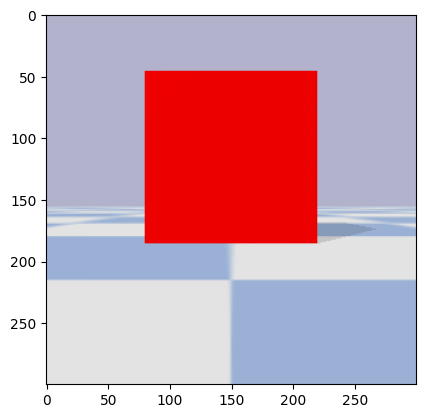

In [15]:
# # Display animation within Jupyter Book
# def update(time, frames):
#     plt.cla()
#     frames_np = np.asarray(frames[time])
#     plt.imshow(frames_np)

# fig = plt.figure()
# time_step_milli_sec = time_step * 1000
# ani = FuncAnimation(fig, update, interval=time_step_milli_sec * save_img_freq, frames=len(frames), fargs=(frames,))
# HTML(ani.to_jshtml()) # Convert to HTML
# # ani.save('robot_camera.mp4', writer="ffmpeg") # Save as mp4. Executing this will increase processing time.
# # ani.save('robot_camera.gif', writer="imagemagick") # Save as gif. Executing this will increase processing time.

# debuged version with Grok
from IPython.display import HTML  # Ensure this is imported if not already
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np

# Display animation within Jupyter Book
def update(time, frames):
    plt.cla()
    frames_np = np.asarray(frames[time]).reshape(300, 300, 4)  # Reshape to (height, width, 4) for RGBA
    plt.imshow(frames_np)

fig = plt.figure()
time_step_milli_sec = time_step * 1000
ani = FuncAnimation(fig, update, interval=time_step_milli_sec * save_img_freq, frames=len(frames), fargs=(frames,))
HTML(ani.to_jshtml())  # Convert to HTML
# ani.save('robot_camera.mp4', writer="ffmpeg") # Save as mp4. Executing this will increase processing time.
# ani.save('robot_camera.gif', writer="imagemagick") # Save as gif. Executing this will increase processing time.

## <a id='toc4_2_'></a>[Ultrasonic Sensor](#toc0_)

The ultrasonic sensor measures the distance to obstacles.

Compared to lidar, it has a shorter measurement range but is more affordable.


### <a id='toc4_2_1_'></a>[Definition of the Lidar Class](#toc0_)
The Lidar class is reused for the ultrasonic sensor. (It is exactly the same class used for the Lidar sensor)

In [16]:
import math
import pybullet


class Lidar():
    def __init__(self):
        self.replace_item_uniqueIds = None

    # Rotation matrix representing orientation
    def rotation_matrix(self, roll, pitch, yaw):
        R_x = [[1, 0, 0],
                [0, math.cos(roll), -math.sin(roll)],
                [0, math.sin(roll), math.cos(roll)]]
        
        R_y = [[math.cos(pitch), 0, math.sin(pitch)],
                [0, 1, 0],
                [-math.sin(pitch), 0, math.cos(pitch)]]
        
        R_z = [[math.cos(yaw), -math.sin(yaw), 0],
                [math.sin(yaw), math.cos(yaw), 0],
                [0, 0, 1]]
        
        return np.dot(R_z, np.dot(R_y, R_x))

    def CheckHits(self, ray_from_position, ray_orientation, ray_length, angle_resolution_rad, ray_direction_range_rad, offset, draw_debug_line=False):
        """
        Ray casting for obstacle detection reflecting orientation
        Parameters
        ---
        ray_from_position : list
            List storing the starting position of the ray [x, y, z]
        orientation : list
            Orientation of the ray source [roll, pitch, yaw]
        ray_length : float
            Length of the ray
        angle_resolution_rad : float
            Angular resolution
        ray_direction_range_rad : list
            List storing the range of directions to cast rays [startRad, endRad]
        offset : float
            Offset from rayFromPosition
        draw_debug_line : bool
            Whether to draw the ray
        
        Returns
        ---
        hit_results: tuple
            Results of the ray casting
        """
        
        
        R = self.rotation_matrix(ray_orientation[0], ray_orientation[1], ray_orientation[2])
        
        # Number of divisions
        num_divisions = int((ray_direction_range_rad[1] - ray_direction_range_rad[0]) / angle_resolution_rad)

        # Generate ray start/end points within the range of ray_direction_range_rad for numDivisions
        ray_froms = []
        ray_toes = []
        for i in range(num_divisions):
            angle = ray_direction_range_rad[0] + i * angle_resolution_rad
            direction = [math.cos(angle), math.sin(angle), 0]
            
            # Rotate the direction vector by applying the rotation matrix
            rotated_direction = np.dot(R, direction)

            # Ray start point
            ray_from = ray_from_position + offset * rotated_direction
            ray_froms.append(ray_from)

            # Ray end point
            ray_to = ray_from + ray_length * rotated_direction
            ray_toes.append(ray_to)
        
        # Perform ray casting for numDivisions
        hit_results = pybullet.rayTestBatch(ray_froms, ray_toes)

        # Draw the rays
        if draw_debug_line:
            if self.replace_item_uniqueIds is None:
                self.replace_item_uniqueIds = []
                
                for i in range(num_divisions):
                    isHit = hit_results[i][0]
                    ray_from = ray_froms[i]
                    
                    if isHit != -1:
                        rayHitPosition = hit_results[i][3]
                        self.replace_item_uniqueIds.append(pybullet.addUserDebugLine(ray_from, rayHitPosition, lineColorRGB=[1,0,0]))
                    else:
                        rayToPosition = ray_toes[i]
                        self.replace_item_uniqueIds.append(pybullet.addUserDebugLine(ray_from, rayToPosition, lineColorRGB=[0,1,0]))
            
            else:
                for i in range(num_divisions):
                    isHit = hit_results[i][0]
                    ray_from = ray_froms[i]
                    
                    if isHit != -1:
                        rayHitPosition = hit_results[i][3]
                        pybullet.addUserDebugLine(ray_from, rayHitPosition, lineColorRGB=[1,0,0], replaceItemUniqueId=self.replace_item_uniqueIds[i])
                    else:
                        rayToPosition = ray_toes[i]
                        pybullet.addUserDebugLine(ray_from, rayToPosition, lineColorRGB=[0,1,0], replaceItemUniqueId=self.replace_item_uniqueIds[i])
        return hit_results


### <a id='toc4_2_2_'></a>[Initial Setup](#toc0_)

We will perform initial setup such as creating the floor, generating box objects, creating the robot, and setting the camera position.

In [17]:
pybullet.resetSimulation() # Reset the simulation space
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # Add path to necessary data for pybullet
pybullet.setGravity(0.0, 0.0, -9.8) # Set gravity as on Earth
time_step = 1./240.
pybullet.setTimeStep(time_step)

# Load the floor
plane_id = pybullet.loadURDF("plane.urdf")

# Load the boxes
# Determine the weight, size, position, and orientation of the boxes
# box1
mass = 5 # kg
box1_size = [0.3, 0.3, 0.3]
position2 = [1.5, 0, 0.3]
orientation2 = [1, 0, 0, 0] # Quaternion
box1_collision_id = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box1_size, physicsClientId=physics_client)
box1_visual_id = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box1_size, physicsClientId=physics_client, rgbaColor=[0,1,0,1]) 
box1_body_id = pybullet.createMultiBody(mass, box1_collision_id, box1_visual_id, position2, orientation2, physicsClientId=physics_client)

# Load the robot
car_start_pos = [0, 0, 0.1]  # Set the initial position (x, y, z)
car_start_orientation = pybullet.getQuaternionFromEuler([0, 0, 0])  # Set the initial orientation (roll, pitch, yaw)
car_id = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf", car_start_pos, car_start_orientation)

# Set the camera position and other parameters in GUI mode
camera_distance = 2.0
camera_yaw = 180.0 # deg
camera_pitch = -90.5 # deg
camera_target_position = [1.0, 0.0, 0.0]
pybullet.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

### <a id='toc4_2_3_'></a>[Running the Simulation](#toc0_)

While the Lidar sensor measures the distance to obstacles in all directions, the commonly available and affordable ultrasonic sensor HC-SR04 has a measurable range of about ±15 degrees. Therefore, we set the range accordingly.

When the simulation is run, the robot starts moving. If an obstacle approaches within a short distance in front of the robot, the sensor detects it, and the robot stops on the spot.

In [19]:
# Initialize debug drawing
pybullet.removeAllUserDebugItems()

# Set the robot to the initial position
car_start_pos = [0, 0, 0.1]
car_start_orientation = pybullet.getQuaternionFromEuler([0.0, 0.0, 0.0])
pybullet.resetBasePositionAndOrientation(car_id, car_start_pos, car_start_orientation)

# Set up the rays
ULTRA_SONIC_SENSOR_LINK_IDX = 6 # Index of the link from which the rays are emitted
ray_direction_start_deg = -15
ray_direction_end_deg = 15
ray_direction_range_rad = [math.radians(ray_direction_start_deg), math.radians(ray_direction_end_deg)] # Range of the rays
angle_resolution_deg = 5 # Angular resolution
angle_resolution_rad = math.radians(angle_resolution_deg)
ray_length = 10 # Length of the rays
offset = 0.01

# Move the mobile robot forward while updating lidar information
ultra_sonic_sensor = Lidar()
for i in range(1000):
    # Control the speed to move the two wheels forward
    pybullet.setJointMotorControl2(car_id, 0, pybullet.VELOCITY_CONTROL, targetVelocity=10)
    pybullet.setJointMotorControl2(car_id, 1, pybullet.VELOCITY_CONTROL, targetVelocity=10)

    # Draw the lidar information after moving
    ultra_sonic_sensor_position = pybullet.getLinkState(car_id, ULTRA_SONIC_SENSOR_LINK_IDX) # Get the information of the lidar link
    ray_from_position = [ultra_sonic_sensor_position[0][0], ultra_sonic_sensor_position[0][1], ultra_sonic_sensor_position[0][2]] # Set the starting point of the rays to the origin of the lidar link
    ultra_sonic_sensor_orientation = list(pybullet.getEulerFromQuaternion(ultra_sonic_sensor_position[1]))
    result = ultra_sonic_sensor.CheckHits(ray_from_position, ultra_sonic_sensor_orientation, ray_length, angle_resolution_rad, ray_direction_range_rad, offset, draw_debug_line=True) # Get the lidar information
    
    # If the distance in the result is less than 10 cm, stop
    for i in range(len(result)):
        if result[i][2] < 0.01:
            pybullet.setJointMotorControl2(car_id, 0, pybullet.VELOCITY_CONTROL, targetVelocity=0)
            pybullet.setJointMotorControl2(car_id, 1, pybullet.VELOCITY_CONTROL, targetVelocity=0)
            break
    pybullet.stepSimulation()
    time.sleep(time_step)

# <a id='toc5_'></a>[Bumper](#toc0_)

The bumper sensor detects whether the robot has collided with an obstacle.


## <a id='toc5_1_'></a>[Initial Setup](#toc0_)

We will perform initial setup such as creating the floor, generating box objects, creating the robot, and setting the camera position.

In [20]:
pybullet.resetSimulation() # Reset the simulation space
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # Add path to necessary data for pybullet
pybullet.setGravity(0.0, 0.0, -9.8) # Set gravity as on Earth
time_step = 1./240.
pybullet.setTimeStep(time_step)

# Load the floor
plane_id = pybullet.loadURDF("plane.urdf")

# Load the boxes
# Determine the weight, size, position, and orientation of the boxes
# box1
mass = 5 # kg
box1_size = [0.3, 0.3, 0.3]
position2 = [0.8, 0, 0.3]
orientation2 = [1, 0, 0, 0] # Quaternion
box1_collision_id = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box1_size, physicsClientId=physics_client)
box1_visual_id = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box1_size, physicsClientId=physics_client, rgbaColor=[1,0,0,1]) # Red, semi-transparent
box1_body_id = pybullet.createMultiBody(mass, box1_collision_id, box1_visual_id, position2, orientation2, physicsClientId=physics_client)


# Load the robot
car_start_pos = [0, 0, 0.1]  # Set the initial position (x, y, z)
car_start_orientation = pybullet.getQuaternionFromEuler([0, 0, 0])  # Set the initial orientation (roll, pitch, yaw)
car_id = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf", car_start_pos, car_start_orientation)

# Set the camera position and other parameters in GUI mode
camera_distance = 2.0
camera_yaw = 180.0 # deg
camera_pitch = -90.1 # deg
camera_target_position = [0.0, 0.0, 0.0]
pybullet.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

## <a id='toc5_2_'></a>[Running the Simulation](#toc0_)
In pybullet, you can obtain information about each joint using the `getJointState` function.  
This function can retrieve force information in addition to position information, so the bumper sensor uses force information to detect collisions with obstacles.

When the simulation starts, the mobile robot begins to move, and it stops when the bumper contacts an obstacle in front.

- Setting `enableSensor` to 1 in `enableJointForceTorqueSensor` will stop the robot when the bumper contacts an obstacle.
- Setting `enableSensor` to 0 in `enableJointForceTorqueSensor` will cause the robot to continue moving forward even if the bumper contacts an obstacle.

In [28]:
# Initialize debug drawing
pybullet.removeAllUserDebugItems()
replace_unique_id_force_text = None
replace_unique_id_bumper_on_text = None

FORCE_SENSOR_JOINT_IDX = 4  # Index of the joint with the force sensor
pybullet.enableJointForceTorqueSensor(car_id, FORCE_SENSOR_JOINT_IDX, enableSensor=1) # Enable the force sensor

# Set the robot to the initial position
car_start_pos = [0, 0, 0.1]
car_start_orientation = pybullet.getQuaternionFromEuler([0.0, 0.0, 0.0])
pybullet.resetBasePositionAndOrientation(car_id, car_start_pos, car_start_orientation)

enable_debug_text = False # Whether to display debug text (displaying it slows down the processing)

for i in range(1000):
    # Get the force applied to the bumper
    joint_state = pybullet.getJointState(car_id, FORCE_SENSOR_JOINT_IDX)
    force_x = joint_state[2][0]
    force_y = joint_state[2][1]
    force_z = joint_state[2][2]

    if enable_debug_text:
        if replace_unique_id_force_text is None:
            replace_unique_id_force_text = pybullet.addUserDebugText(f"force x:{force_x:.2f} y:{force_y:.2f} z:{force_z:.2f}", [-1.0, -0.5, 0.0], textSize=2, textColorRGB=[0,0,0])
        else:
            pybullet.addUserDebugText(f"force x:{force_x:.2f} y:{force_y:.2f} z:{force_z:.2f}", [-1.0, -0.5, 0.0], textSize=2, textColorRGB=[0,0,0], replaceItemUniqueId=replace_unique_id_force_text)

    bumper_on_text_position = [-0.5, 0.5, 0.5]
    # Stop if a force greater than 5 is applied to the bumper
    if force_x > 5:
        if enable_debug_text:
            if replace_unique_id_bumper_on_text is None:
                replace_unique_id_bumper_on_text = pybullet.addUserDebugText(f"bumper ON", [0.0, -0.1, 1.0], textSize=5, textColorRGB=[1,0,0])
            else:
                pybullet.addUserDebugText(f"bumper ON", [0.0, -0.1, 1.0], textSize=5, lifeTime=0.1, textColorRGB=[1,0,0], replaceItemUniqueId=replace_unique_id_bumper_on_text)
        pybullet.setJointMotorControl2(car_id, 0, pybullet.VELOCITY_CONTROL, targetVelocity=0)
        pybullet.setJointMotorControl2(car_id, 1, pybullet.VELOCITY_CONTROL, targetVelocity=0)
    else:
        if enable_debug_text:
            if replace_unique_id_bumper_on_text is None:
                replace_unique_id_bumper_on_text = pybullet.addUserDebugText(f"", [0.0, -0.1, 1.0], textSize=5, textColorRGB=[1,0,0])
            else:
                pybullet.addUserDebugText(f"", [0.0, -0.1, 1.0], textSize=5, lifeTime=0.1, textColorRGB=[1,0,0], replaceItemUniqueId=replace_unique_id_bumper_on_text)
        # Move forward
        pybullet.setJointMotorControl2(car_id, 0, pybullet.VELOCITY_CONTROL, targetVelocity=10)
        pybullet.setJointMotorControl2(car_id, 1, pybullet.VELOCITY_CONTROL, targetVelocity=10)

    # Proceed to the next step
    pybullet.stepSimulation()
    time.sleep(time_step)

b3Printf: b3Warning[examples/SharedMemory/PhysicsServerCommandProcessor.cpp,10339]:

b3Printf: CMD_CREATE_SENSOR: sensor for joint [4] already enabled


# <a id='toc6_'></a>[Bottom Sensor](#toc0_)
The `bottom_sensor_link` can simulate two types of sensors in a single link:

- Bottom Camera
- Fall Prevention Sensor

## <a id='toc6_1_'></a>[Bottom Camera](#toc0_)
The bottom camera can capture images of the ground.

Similar to the front camera, images are captured using the `getCameraImage` function.

### <a id='toc6_1_1_'></a>[Initial Setup](#toc0_)

We will perform initial setup such as creating the floor, generating box objects, creating the robot, and setting the camera position.

In [30]:
pybullet.resetSimulation() # Reset the simulation space
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # Add path to necessary data for pybullet
pybullet.setGravity(0.0, 0.0, -9.8) # Set gravity as on Earth
time_step = 1./240.
pybullet.setTimeStep(time_step)

# Load the floor
plane_id = pybullet.loadURDF("plane.urdf")

# Load the boxes
# Determine the weight, size, position, and orientation of the boxes
# box1
mass = 5 # kg
box1_size = [0.3, 0.3, 0.3]
position2 = [2, 0, 0.3]
orientation2 = [1, 0, 0, 0] # Quaternion
box1_collision_id = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box1_size, physicsClientId=physics_client)
box1_visual_id = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box1_size, physicsClientId=physics_client, rgbaColor=[1,0,0,1]) # Red, semi-transparent
box1_body_id = pybullet.createMultiBody(mass, box1_collision_id, box1_visual_id, position2, orientation2, physicsClientId=physics_client)

# box2
mass = 5 # kg
box2_size = [0.3, 1.0, 0.3]
position2 = [-2, 0, 0.3]
orientation2 = [1, 0, 0, 0] # Quaternion
box2_collision_id = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=box2_size, physicsClientId=physics_client)
box2_visual_id = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=box2_size, physicsClientId=physics_client, rgbaColor=[1,0,0,1]) # Red, semi-transparent
box2_body_id = pybullet.createMultiBody(mass, box2_collision_id, box2_visual_id, position2, orientation2, physicsClientId=physics_client)

# Load the robot
car_start_pos = [0, 0, 0.1]  # Set the initial position (x, y, z)
car_start_orientation = pybullet.getQuaternionFromEuler([0, 0, 0])  # Set the initial orientation (roll, pitch, yaw)
car_id = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf", car_start_pos, car_start_orientation)

# Set the camera position and other parameters in GUI mode
camera_distance = 5.0
camera_yaw = 0.0 # deg
camera_pitch = -90.1 # deg
camera_target_position = [0.0, 0.0, 0.0]
pybullet.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

In [31]:
# Define rotation matrices to calculate the cameraUpVector according to the movement of the mobile robot
def Rx(theta):
    return np.array([[1, 0, 0],
                     [0, np.cos(theta), -np.sin(theta)],
                     [0, np.sin(theta), np.cos(theta)]])

def Ry(theta):
    return np.array([[np.cos(theta), 0, np.sin(theta)],
                     [0, 1, 0],
                     [-np.sin(theta), 0, np.cos(theta)]])

def Rz(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta), np.cos(theta), 0],
                     [0, 0, 1]])

### <a id='toc6_1_2_'></a>[Running the Simulation](#toc0_)

When the simulation is run, images are captured from the camera mounted under the robot.

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set the robot to the initial position
car_start_pos = [0, 0, 0.1]
car_start_orientation = pybullet.getQuaternionFromEuler([0.0, 0.0, 0.0])
pybullet.resetBasePositionAndOrientation(car_id, car_start_pos, car_start_orientation)

# Time settings
time_length = 200
save_img_freq = 1 # Frequency of saving images (the smaller the value, the smoother the video, but the processing time increases)

# Camera settings
projection_matrix = pybullet.computeProjectionMatrixFOV(fov=45.0, aspect=1.0, nearVal=0.01, farVal=0.15)

# Array to store camera images
frames = []
    
# Link indices
CAMERA_IDX = 8
CAMERA_TARGET_IDX = 9

# Joint indices
RIGHT_WHEEL_JOINT_IDX = 0
LEFT_WHEEL_JOINT_IDX = 1

# Default direction of the camera_up_vector
camera_up_vector = np.array([0, -1, 0])

for t in range(time_length):
    # Control the speed of the four wheels
    pybullet.setJointMotorControl2(car_id, RIGHT_WHEEL_JOINT_IDX, pybullet.VELOCITY_CONTROL, targetVelocity=40)
    pybullet.setJointMotorControl2(car_id, LEFT_WHEEL_JOINT_IDX, pybullet.VELOCITY_CONTROL, targetVelocity=40)
    
    # Advance the simulation by one time step
    pybullet.stepSimulation()

    # Capture camera images at intervals of save_img_freq
    if t % save_img_freq == 0:
        # Get the position of the camera link
        camera_link_pose = pybullet.getLinkState(car_id, CAMERA_IDX)[0]

        # Get the position of the virtual link for the target point
        camera_target_link_pose = pybullet.getLinkState(car_id, CAMERA_TARGET_IDX)[0] 

        # Rotate the cameraUpVector according to the posture of the mobile robot
        mobile_robot_roll, mobile_robot_pitch, mobile_robot_yaw = pybullet.getEulerFromQuaternion(pybullet.getLinkState(car_id, CAMERA_IDX)[1])
        R = Rz(np.deg2rad(90.0) + mobile_robot_yaw) @ Ry(mobile_robot_pitch) @ Rx(mobile_robot_roll)
        rotate_camera_up_vector = R @ camera_up_vector 

        # Get the viewMatrix from the camera link to the virtual link for the target point
        view_matrix = pybullet.computeViewMatrix(
            cameraEyePosition=[camera_link_pose[0], camera_link_pose[1], camera_link_pose[2]],
            cameraTargetPosition=[camera_target_link_pose[0], camera_target_link_pose[1], camera_target_link_pose[2]],
            cameraUpVector=rotate_camera_up_vector)

        # Set the camera information
        # By specifying renderer=pybullet.ER_BULLET_HARDWARE_OPENGL, the image can be captured faster at the expense of quality
        width, height, rgb_img, depth_img, seg_img = pybullet.getCameraImage(300, 300, view_matrix, projection_matrix, renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)
        
        # Store the captured camera image in the list
        frames.append(rgb_img)

### <a id='toc6_1_3_'></a>[Animating Captured Images](#toc0_)

We will animate and display the captured images.

The animation speed may appear faster compared to when displayed on the GUI screen. This is because the `getCameraImage` function is slow, and the actual speed is reflected in the animation generated by the code below.

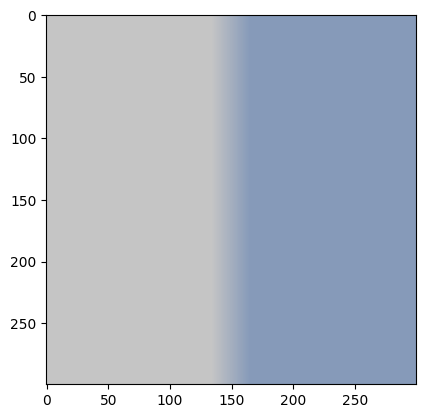

In [33]:
# Display animation within Jupyter Book
def update(time, frames):
    plt.cla()
    frames_np = np.asarray(frames[time]).reshape(300, 300, 4)
    plt.imshow(frames_np)

fig = plt.figure()
time_step_milli_sec = time_step * 1000
ani = FuncAnimation(fig, update, interval=time_step_milli_sec * save_img_freq, frames=len(frames), fargs=(frames,))
HTML(ani.to_jshtml()) # Convert to HTML
# ani.save('robot_camera.mp4', writer="ffmpeg") # Save as mp4. Executing this will increase processing time.
# ani.save('robot_camera.gif', writer="imagemagick") # Save as gif. Executing this will increase processing time.

## <a id='toc6_2_'></a>[Fall Prevention Sensor](#toc0_)

The fall prevention sensor can determine whether there is a floor below the front of the robot.

### <a id='toc6_2_1_'></a>[Definition of the Lidar Class](#toc0_)

The fall prevention sensor reuses the Lidar class (it is exactly the same class used for the Lidar sensor).

In [34]:
import math
import pybullet

class Lidar():
    def __init__(self):
        self.replace_item_uniqueIds = None

    # Rotation matrix representing orientation
    def rotation_matrix(self, roll, pitch, yaw):
        R_x = [[1, 0, 0],
                [0, math.cos(roll), -math.sin(roll)],
                [0, math.sin(roll), math.cos(roll)]]
        
        R_y = [[math.cos(pitch), 0, math.sin(pitch)],
                [0, 1, 0],
                [-math.sin(pitch), 0, math.cos(pitch)]]
        
        R_z = [[math.cos(yaw), -math.sin(yaw), 0],
                [math.sin(yaw), math.cos(yaw), 0],
                [0, 0, 1]]
        
        return np.dot(R_z, np.dot(R_y, R_x))

    def CheckHits(self, ray_from_position, ray_orientation, ray_length, angle_resolution_rad, ray_direction_range_rad, offset, draw_debug_line=False):
        """
        Ray casting for obstacle detection reflecting orientation
        Parameters
        ---
        ray_from_position : list
            List storing the starting position of the ray [x, y, z]
        orientation : list
            Orientation of the ray source [roll, pitch, yaw]
        ray_length : float
            Length of the ray
        angle_resolution_rad : float
            Angular resolution
        ray_direction_range_rad : list
            List storing the range of directions to cast rays [startRad, endRad]
        offset : float
            Offset from rayFromPosition
        draw_debug_line : bool
            Whether to draw the ray
        
        Returns
        ---
        hit_results: tuple
            Results of the ray casting
        """
        
        
        R = self.rotation_matrix(ray_orientation[0], ray_orientation[1], ray_orientation[2])
        
        # Number of divisions
        num_divisions = int((ray_direction_range_rad[1] - ray_direction_range_rad[0]) / angle_resolution_rad)

        # Generate ray start/end points within the range of ray_direction_range_rad for numDivisions
        ray_froms = []
        ray_toes = []
        for i in range(num_divisions):
            angle = ray_direction_range_rad[0] + i * angle_resolution_rad
            direction = [math.cos(angle), math.sin(angle), 0]
            
            # Rotate the direction vector by applying the rotation matrix
            rotated_direction = np.dot(R, direction)

            # Ray start point
            ray_from = ray_from_position + offset * rotated_direction
            ray_froms.append(ray_from)

            # Ray end point
            ray_to = ray_from + ray_length * rotated_direction
            ray_toes.append(ray_to)
        
        # Perform ray casting for numDivisions
        hit_results = pybullet.rayTestBatch(ray_froms, ray_toes)

        # Draw the rays
        if draw_debug_line:
            if self.replace_item_uniqueIds is None:
                self.replace_item_uniqueIds = []
                
                for i in range(num_divisions):
                    isHit = hit_results[i][0]
                    ray_from = ray_froms[i]
                    
                    if isHit != -1:
                        rayHitPosition = hit_results[i][3]
                        self.replace_item_uniqueIds.append(pybullet.addUserDebugLine(ray_from, rayHitPosition, lineColorRGB=[1,0,0]))
                    else:
                        rayToPosition = ray_toes[i]
                        self.replace_item_uniqueIds.append(pybullet.addUserDebugLine(ray_from, rayToPosition, lineColorRGB=[0,1,0]))
            
            else:
                for i in range(num_divisions):
                    isHit = hit_results[i][0]
                    ray_from = ray_froms[i]
                    
                    if isHit != -1:
                        rayHitPosition = hit_results[i][3]
                        pybullet.addUserDebugLine(ray_from, rayHitPosition, lineColorRGB=[1,0,0], replaceItemUniqueId=self.replace_item_uniqueIds[i])
                    else:
                        rayToPosition = ray_toes[i]
                        pybullet.addUserDebugLine(ray_from, rayToPosition, lineColorRGB=[0,1,0], replaceItemUniqueId=self.replace_item_uniqueIds[i])
        return hit_results

### <a id='toc6_2_2_'></a>[Initial Setup](#toc0_)

We will perform initial setup such as creating the floor, generating box objects, creating the robot, and setting the camera position.

In [35]:
pybullet.resetSimulation() # Reset the simulation space
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # Add path to necessary data for pybullet
pybullet.setGravity(0.0, 0.0, -9.8) # Set gravity as on Earth

# Load the floor
plane_id = pybullet.loadURDF("plane.urdf")

# Load the robot
car_start_pos = [0, 0, 1.0]
car_start_orientation = pybullet.getQuaternionFromEuler([0, 0, 0])  # Set the initial orientation (roll, pitch, yaw)
# The mesh in the urdf file does not seem to reflect textures, so each link is colored with the rgba tag
car_id = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf", car_start_pos, car_start_orientation)

# Load the box
# Determine the weight, size, position, and orientation of the box
mass = 5 # kg
position = [-4.5, -4.5, 0.3]
orientation = [1, 0, 0, 0] # Quaternion
# Place the box fixed to the ground
boxId = pybullet.loadURDF("../urdf/plane_box.urdf", position, orientation, useFixedBase=True)

# Set the camera position and other parameters in GUI mode
# Set to view from the front
camera_distance = 1.0
camera_yaw = -70.1 # deg
camera_pitch = 210.1 # deg
camera_target_position = [0.0, 0.0, 0.5]
pybullet.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

### <a id='toc6_2_3_'></a>[Running the Simulation](#toc0_)
While Lidar and ultrasonic sensors cast rays horizontally, the fall prevention sensor casts rays vertically to determine whether there is a floor.

When the simulation is run, the robot is generated on a floor with steps and starts moving.  
If the robot is about to fall off the floor, the fall prevention sensor detects it, and the robot stops on the spot.

In [ ]:
# Initialize debug drawing
pybullet.removeAllUserDebugItems()
time_step = 1./240.
pybullet.setTimeStep(time_step)

# Set the robot to the initial position
car_start_pos = [0, 0, 1.0]
car_start_orientation = pybullet.getQuaternionFromEuler([0.0, 0.0, 0.0])
pybullet.resetBasePositionAndOrientation(car_id, car_start_pos, car_start_orientation)

# Set up the rays
LIDAR_LINK_IDX = 8 # Index of the link from which the bottom sensor rays are emitted
ray_direction_start_deg = -90
ray_direction_end_deg = 90
ray_direction_range_rad = [math.radians(ray_direction_start_deg), math.radians(ray_direction_end_deg)] # Range of the rays
angle_resolution_deg = 5 # Angular resolution
angle_resolution_rad = math.radians(angle_resolution_deg)
ray_length = 0.1 # Length of the rays
offset = 0.05

lidar = Lidar()
for i in range(500):
    # Control the speed to move the two wheels forward
    pybullet.setJointMotorControl2(car_id, 0, pybullet.VELOCITY_CONTROL, targetVelocity=10)
    pybullet.setJointMotorControl2(car_id, 1, pybullet.VELOCITY_CONTROL, targetVelocity=10)

    # Draw the lidar information after moving
    lidar_position = pybullet.getLinkState(car_id, LIDAR_LINK_IDX) # Get the information of the lidar link
    ray_from_position = [lidar_position[0][0], lidar_position[0][1], lidar_position[0][2]] # Set the starting point of the rays to the origin of the lidar link
    
    # Get the orientation of the robot
    orientation = list(pybullet.getEulerFromQuaternion(lidar_position[1]))
    orientation[1] += math.radians(90)
    ray_results = lidar.CheckHits(ray_from_position, orientation, ray_length, angle_resolution_rad, ray_direction_range_rad, offset, draw_debug_line=True) # Get the lidar information

    # Check if the rays are hitting an obstacle
    is_hit = False
    for ray_result in ray_results:
        if ray_result[0] != -1:
            is_hit = True
            break
    
    # If the rays are not hitting an obstacle, determine that there is no floor ahead and stop the robot
    if is_hit is False:
        # Stop the robot
        pybullet.setJointMotorControl2(car_id, 0, pybullet.VELOCITY_CONTROL, targetVelocity=0)
        pybullet.setJointMotorControl2(car_id, 1, pybullet.VELOCITY_CONTROL, targetVelocity=0)
        break

    pybullet.stepSimulation()
    time.sleep(time_step)

: 